<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Construcción y Comparación de Modelos de Clasificación

El objetivo de esta práctica es construir múltiples modelos de clasificación para predecir la probabilidad de que una transacción sea fraudulenta. Además de implementar los modelos, deberás analizar y comparar las métricas obtenidas para seleccionar el modelo que mejor se ajuste al problema. En este laboratorio deberás: 



- Entrenar al menos tres modelos diferentes de clasificación, como:

   - **Regresión logística**

   - **Árboles de decisión**

   - **Bosques aleatorios**

   - etc.


- Obtener las siguientes métricas para cada modelo:

   - Precisión

   - Recall (Sensibilidad)

   - F1-Score

   - Área bajo la curva ROC (AUC-ROC)

   - Matriz de confusión

   - Accuracy

- Visualizar y comparar estas métricas en gráficos claros y explicativos.


- Analizar las métricas de rendimiento de cada modelo.

- Justificar la selección del modelo más adecuado en función del equilibrio entre precisión y recall, así como la interpretación del área bajo la curva ROC.


# 0. Imports

### 0.1 Import packages

In [32]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sys 
sys.path.append("..")

import src.soporte_ajuste_logistica_miercoles as salm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1 Import data

Se importa el dataset preprocesado desde un pickle.

In [4]:
financial_df = pd.read_pickle("../datos/financial_df_preprocesado.pkl")

### 2 Evaluación de modelos

Se instancia un objeto 'ajustador' de la clase de ajuste y análisis de modelos.

In [24]:
ajustador = salm.AnalisisModelosClasificacion(financial_df,"is_fraudulent")

Se comienza por el modelo más sencillo, la regresión logística.

#### 2.1 Regresión logística

In [25]:
ajustador.ajustar_modelo("logistic_regression")
ajustador.calcular_metricas("logistic_regression")

Fitting 5 folds for each of 43 candidates, totalling 215 fits


,accuracy,precision,recall,f1,kappa,auc,time_seconds,n_jobs
train,0.56125,0.561194,0.56125,0.561060,0.122183,0.585769,0.004019,12.0
test,0.56750,0.567129,0.56750,0.567195,0.133143,0.596806,0.004019,12.0


Observando las métricas, rápidamente se puede concluir que si bien el modelo no tiene unos resultados excelentes, no comete overfitting. Las métricas del train y el test son prácticamente las mismas, incluso algo mejores para el test. El kappa indica que el ajuste es ligeramente mejor que un modelo naive o debido a la suerte.

Es llamativo el hecho de que las métricas de accuracy, precision y recall se parezcan tanto. Este hecho podría deberse a que, a pesar de que el modelo no estima bien las probabilidades, estas están bien centradas y con un umbral de clasificación por defecto de 0.5 se obtiene la misma "contaminación" de falsos positivos y falsos negativos a la derecha que a la izquierda del umbral, respectivamente. 

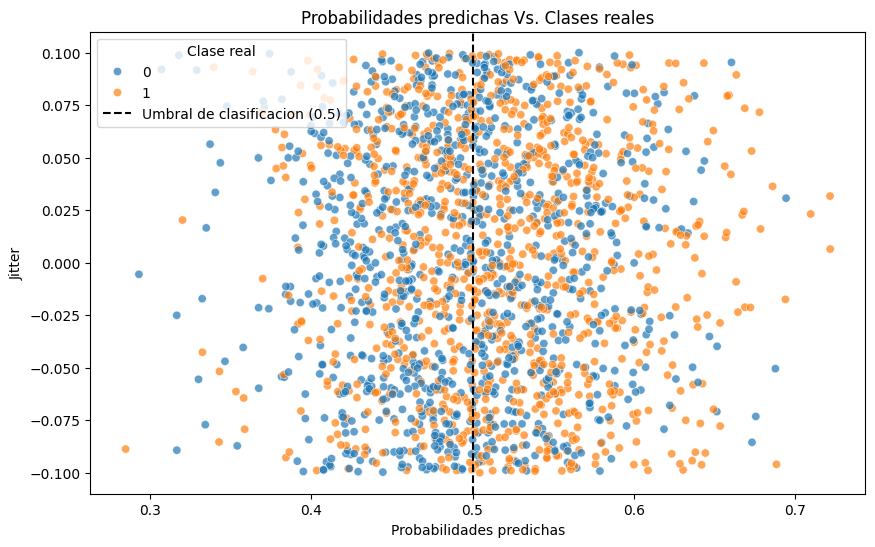

In [46]:
y_test_pred_prob = ajustador.resultados["logistic_regression"]["pred_test_prob"]
y_test = ajustador.y_test
y_test_pred = ajustador.resultados["logistic_regression"]["pred_test"]

# añadir jitter para separar verticalmente los puntos
jitter = np.random.uniform(-0.1, 0.1, len(y_test_pred))


data = pd.DataFrame({
    "Prob": y_test_pred_prob,
    "True Class": y_test,
    "Y Pos": jitter  
})


plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data,
    x="Prob",
    y="Y Pos",
    hue="True Class",
    alpha=0.7
)

# añadir linea umbral
plt.axvline(x=0.5, color="black", linestyle="--", label="Umbral de clasificacion (0.5)")

# configurar ejes y leyenda
plt.title("Probabilidades predichas Vs. Clases reales")
plt.xlabel("Probabilidades predichas")
plt.ylabel("Jitter")
plt.legend(title="Clase real")
plt.show()

Como se observa en el gráfico, parece que efectivamente la mezcla de puntos es alta, pero es homogénea a sendos lados del umbral de decisión.

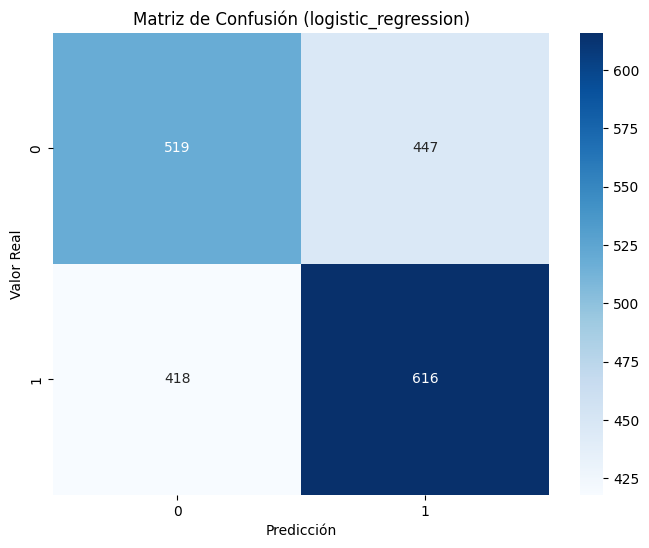

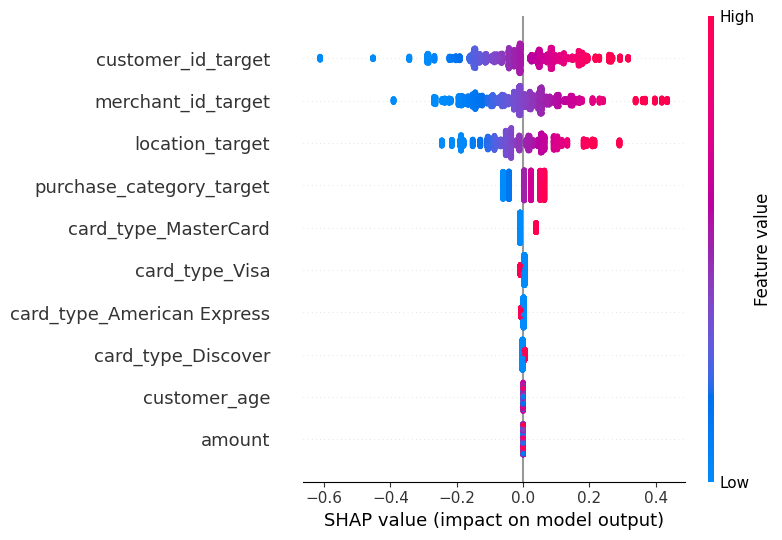

c:\Users\Miguel\Desktop\Hackio\Semana 9 - Logística\labs\..\src\soporte_ajuste_logistica_miercoles.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plt.title(f"Importancia de Características ({modelo_nombre})")


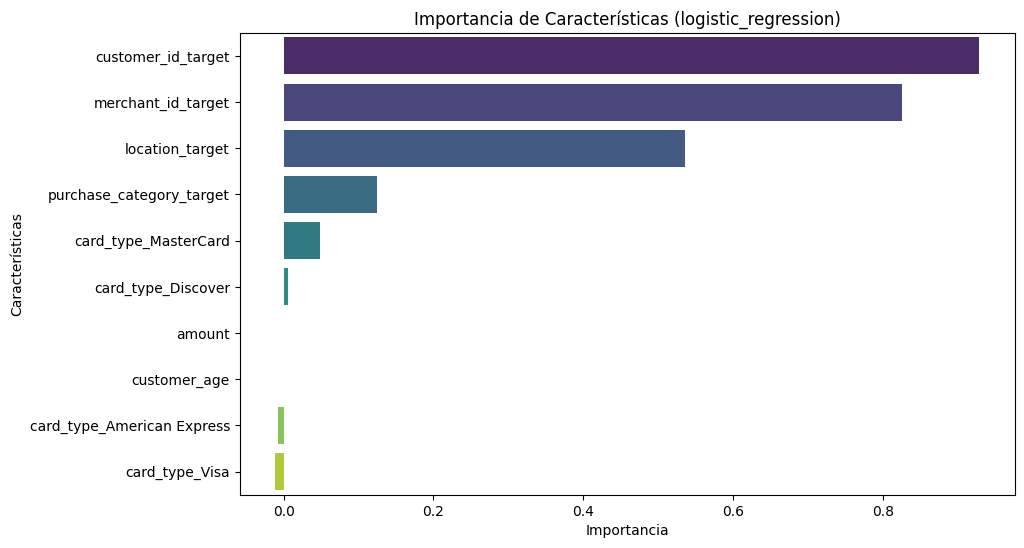

In [26]:
ax = ajustador.plot_matriz_confusion("logistic_regression")

ax2 = ajustador.plot_shap_summary("logistic_regression")

ajustador.importancia_predictores("logistic_regression")

Las variables que a priori no parecían tener variabilidad entre clases, customer_id, merchant_id y location son encontradas por el modelo de regresión logística como las predictoras más fuertes. Seguidamente, pero con mucho menos efecto están la purchase_category y los tipos de tarjeta. Estas importancias se corresponden con el análisis visual de la diferencia de clases entre categorías.

Analizando los SHAP values, se observa que las 4 primeras, debido al target tienen sus valores ordenados con respecto al efecto positivo o negativo en el modelo. Es decir, a valores más bajos de sus variables, menor contribución a la predicción de clase positiva, debido a que sus valores bajos se corresponden con categorías que presentaban una baja media de la variable respuesta. Esto apunta a que el encoding es correcto, pero la interpretación sobre el significado de cada categoría es complicada. Por otro lado, es interesante ver que las operaciones con Mastercard tienen más posibilidad de ser fraudulentas, mientras que las de Visa tienen menos.

Interpretando la matriz de confusion, se observa por qué el valor de Kappa es bajo. Teniendo en cuenta que la predicción a la suerte daría un accuracy del 50%, se ve que la matriz de confusión asigna correctamente (VP y VN) poco mejor que el 50% de las veces, habiendo un reparto casi homogéneo entre todos los cuadrantes. 

Finalmente, se podría tunear el umbral de decisión para obtener el valor de precisión deseado donde, viendo que el reparto entre error de clases a lo largo del eje de probabilidades es homogéneo, no parece que haya ningún punto de la curva ROC que aporte un salto cuantitativo en Precisión a cambio de poca pérdida de Recall.

#### 2.2 Decision Tree

In [47]:
ajustador.ajustar_modelo("tree")
ajustador.calcular_metricas("tree")

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,accuracy,precision,recall,f1,kappa,auc,time_seconds,n_jobs
train,0.566125,0.571025,0.566125,0.556286,0.130048,0.595963,0.001921,12.0
test,0.536000,0.534183,0.536000,0.525545,0.062501,0.556378,0.001921,12.0


#### 2.3 Random Forest

In [27]:
ajustador.ajustar_modelo("random_forest")
ajustador.calcular_metricas("random_forest")

Fitting 5 folds for each of 60 candidates, totalling 300 fits


,accuracy,precision,recall,f1,kappa,auc,time_seconds,n_jobs
train,0.820375,0.820810,0.820375,0.820276,0.640604,0.911841,0.070668,12.0
test,0.543500,0.542355,0.543500,0.541538,0.082790,0.569290,0.070668,12.0


#### 2.4 Gradient boosting

In [29]:
ajustador.ajustar_modelo("gradient_boosting")
ajustador.calcular_metricas("gradient_boosting")

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,accuracy,precision,recall,f1,kappa,auc,time_seconds,n_jobs
train,0.570,0.570648,0.570,0.568082,0.139023,0.602645,0.025988,12.0
test,0.542,0.540770,0.542,0.539740,0.079493,0.567561,0.025988,12.0


#### 2.5 Xgboost

In [30]:
ajustador.ajustar_modelo("xgboost")
ajustador.calcular_metricas("xgboost")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,accuracy,precision,recall,f1,kappa,auc,time_seconds,n_jobs
train,0.5675,0.568205,0.5675,0.565362,0.133966,0.600783,0.007,12.0
test,0.5420,0.540770,0.5420,0.539740,0.079493,0.567660,0.007,12.0


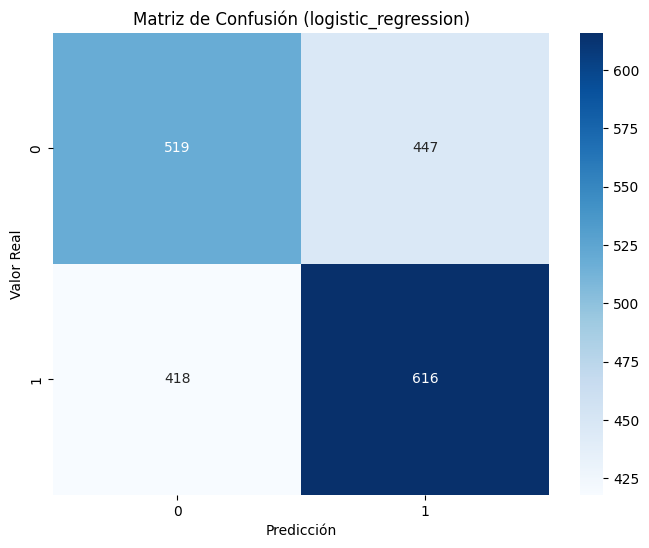

In [24]:
ajustador.plot_matriz_confusion("logistic_regression")

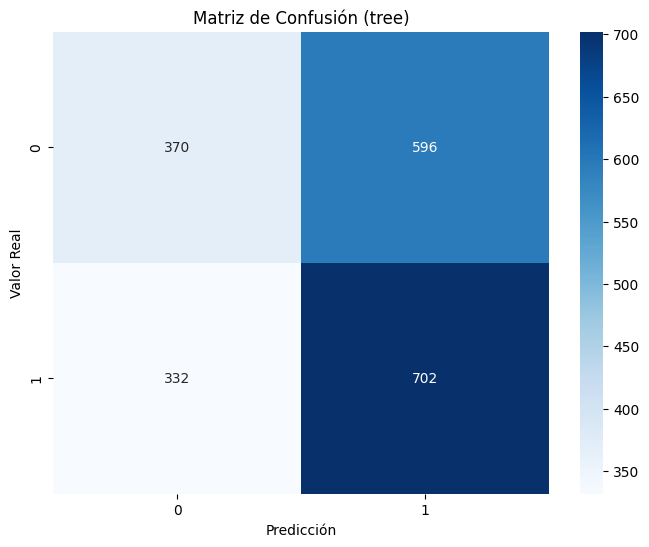

In [28]:
ajustador.plot_matriz_confusion("tree")

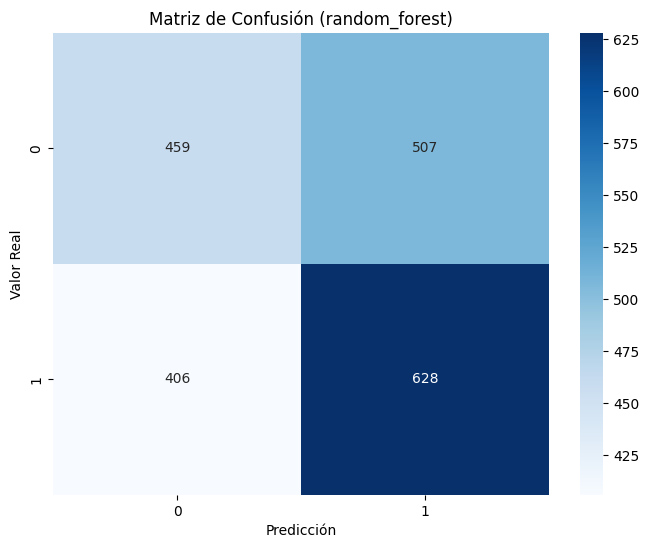

In [31]:
ajustador.plot_matriz_confusion("random_forest")

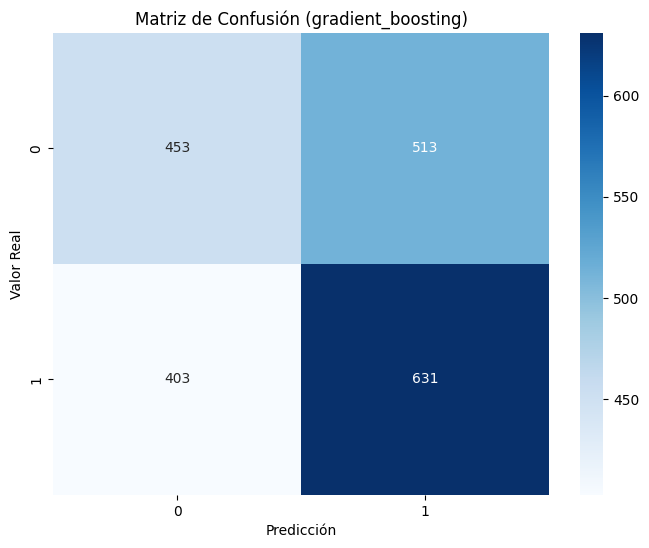

c:\Users\Miguel\Desktop\Hackio\Semana 9 - Logística\labs\..\src\soporte_ajuste_logistica_miercoles.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importancia_df, palette="viridis")


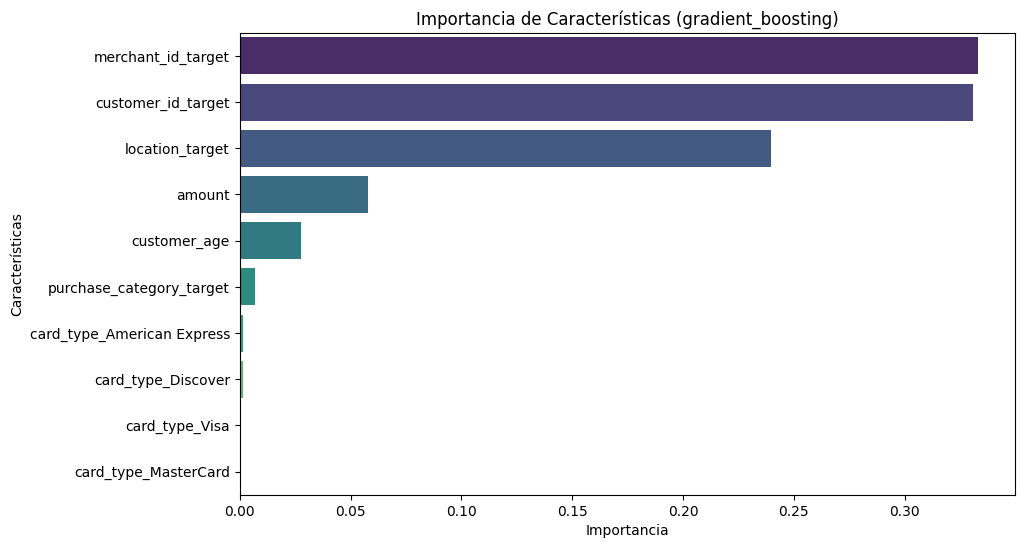

In [20]:
ajustador.plot_matriz_confusion("gradient_boosting")

ajustador.importancia_predictores("gradient_boosting")

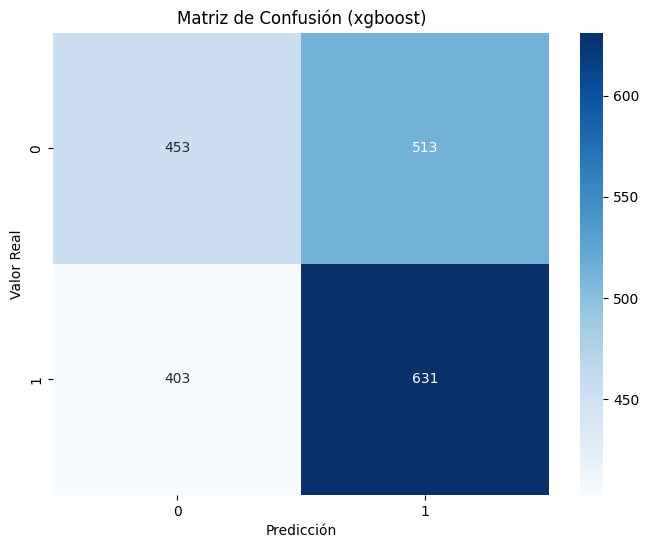

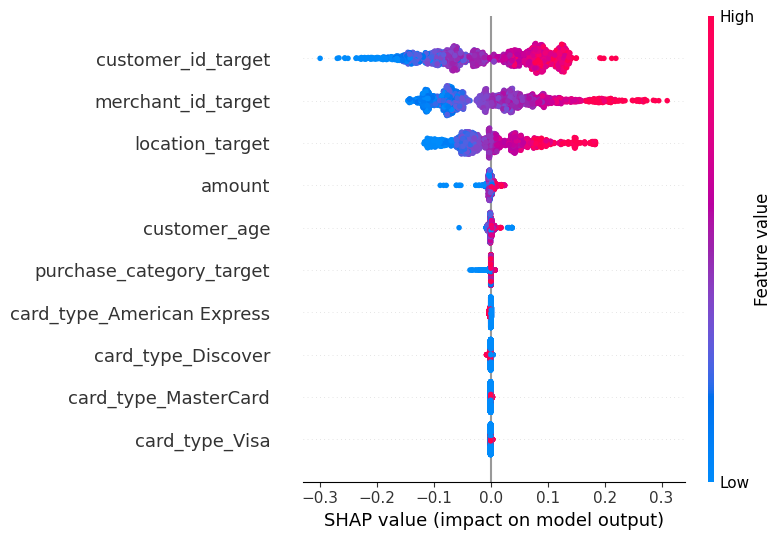

c:\Users\Miguel\Desktop\Hackio\Semana 9 - Logística\labs\..\src\soporte_ajuste_logistica_miercoles.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importancia_df, palette="viridis")


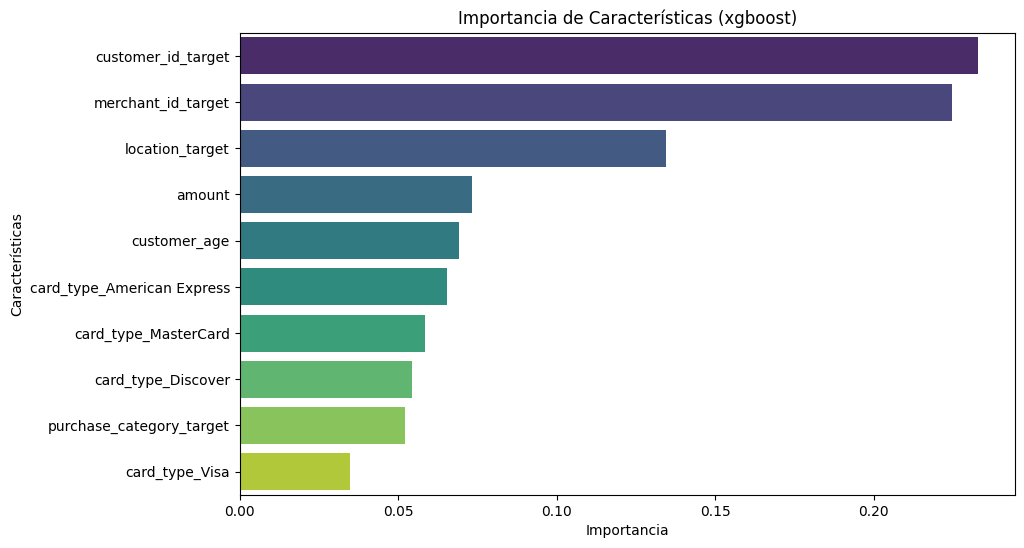

In [22]:
ax = ajustador.plot_matriz_confusion("xgboost")

ax2 = ajustador.plot_shap_summary("xgboost")

ajustador.importancia_predictores("xgboost")

In [17]:
total_scores_df = pd.concat([ajustador.calcular_metricas(model).assign(modelo=model) for model in ajustador.modelos]).reset_index()

styled_df = total_scores_df.style.apply(salm.color_filas_por_modelo, axis=1)

styled_df

,index,accuracy,precision,recall,f1,kappa,auc,time_seconds,n_jobs,modelo
0,train,0.561250,0.561194,0.561250,0.561060,0.122183,0.585769,0.004001,12.000000,logistic_regression
1,test,0.567500,0.567129,0.567500,0.567195,0.133143,0.596806,0.004001,12.000000,logistic_regression
2,train,0.566125,0.571025,0.566125,0.556286,0.130048,0.595963,0.002989,12.000000,tree
3,test,0.536000,0.534183,0.536000,0.525545,0.062501,0.556378,0.002989,12.000000,tree
4,train,0.820375,0.820810,0.820375,0.820276,0.640604,0.911841,0.070558,12.000000,random_forest
5,test,0.543500,0.542355,0.543500,0.541538,0.082790,0.569290,0.070558,12.000000,random_forest
6,train,0.570000,0.570648,0.570000,0.568082,0.139023,0.602645,0.023087,12.000000,gradient_boosting
7,test,0.542000,0.540770,0.542000,0.539740,0.079493,0.567561,0.023087,12.000000,gradient_boosting
8,train,0.567500,0.568205,0.567500,0.565362,0.133966,0.600783,0.010897,12.000000,xgboost
9,test,0.542000,0.540770,0.542000,0.539740,0.079493,0.567660,0.010897,12.000000,xgboost


In [ ]:
total_scores_df

## Optimizando Random Forest

In [32]:
ajustador.resultados["random_forest"]["mejor_modelo"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [33]:
ajustador2 = salm.AnalisisModelosClasificacion(financial_df, "is_fraudulent")

param_grid2 = {
    'n_estimators': [90, 100, 110],  
    'max_depth': [8, 10, 12],      
    'min_samples_split': [3, 5, 7], 
    'min_samples_leaf': [3, 4, 5],  
    'max_features': ['log2'],
    'n_jobs': [-1]        
}

ajustador2.ajustar_modelo("random_forest",param_grid=param_grid2)
ajustador2.calcular_metricas("random_forest")

Fitting 5 folds for each of 81 candidates, totalling 405 fits


,accuracy,precision,recall,f1,kappa,auc,time_seconds,n_jobs
train,0.815625,0.815817,0.815625,0.815569,0.631138,0.903847,0.088679,12.0
test,0.541500,0.540534,0.541500,0.540213,0.079526,0.569668,0.088679,12.0


In [34]:
ajustador2.resultados["random_forest"]["mejor_modelo"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 90,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [35]:
ajustador3 = salm.AnalisisModelosClasificacion(financial_df, "is_fraudulent")

param_grid3 = {
    'n_estimators': [50, 70, 90],  # Test smaller forests
    'max_depth': [5, 6, 7],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 'log2', 0.5],
    'max_leaf_nodes': [10, 20, 30],
    'min_impurity_decrease': [0.0, 0.001, 0.01]
}

ajustador3.ajustar_modelo("random_forest",param_grid=param_grid3)
ajustador3.calcular_metricas("random_forest")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


,accuracy,precision,recall,f1,kappa,auc,time_seconds,n_jobs
train,0.6015,0.602329,0.6015,0.600150,0.202210,0.650737,0.052013,12.0
test,0.5540,0.553164,0.5540,0.552822,0.104713,0.583775,0.052013,12.0


In [36]:
ajustador3.resultados["random_forest"]["mejor_modelo"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': 30,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [6]:
ajustador4 = salm.AnalisisModelosClasificacion(financial_df, "is_fraudulent")

param_grid4 = {
    'n_estimators': [50, 70, 90],  # Test smaller forests
    'max_depth': [6, 7,8],
    'min_samples_split': [6,7,8,9 ,10, 11],
    'min_samples_leaf': [8,9,10,12,13],
    'max_features': ['sqrt', 'log2', 0.5],
    'max_leaf_nodes': [25,27,30,32,35],
    'min_impurity_decrease': [0.0, 0.001, 0.01]
}

ajustador4.ajustar_modelo("random_forest",param_grid=param_grid4)
ajustador4.calcular_metricas("random_forest")

Fitting 5 folds for each of 12150 candidates, totalling 60750 fits


c:\Users\Miguel\.virtualenvs\Semana_9_-_Logística-npR4E3yV\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,accuracy,precision,recall,f1,kappa,auc,time_seconds,n_jobs
train,0.610875,0.612340,0.610875,0.609013,0.220834,0.664927,0.139766,12.0
test,0.551000,0.549987,0.551000,0.549221,0.098013,0.585077,0.139766,12.0


In [1]:
ajustador4

NameError: name 'ajustador4' is not defined